In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

In [2]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 4 GPUs.  Setting memory growth = True.


In [3]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, random_elts, elts_add_mixture_params, elts_add_H
from random_elements import best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [4]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [5]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [6]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [7]:
# Parameters to build random orbital elements and ztf_ast
random_seed = 0
known_ast = True
batch_size_init = 1024
batch_size = 64
thresh_deg = 2.0

In [8]:
# Load ztf nearest asteroid data for known asteroids
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [9]:
# Review ztf_ast
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
602,602,b'ZTF18acqvjbw',689314713015015008,16951,58443.314711,63.025354,17.655906,0.432230,0.899796,-0.059531,18.519199,1.000000,135355,3.663691e-06,63.025567,17.655961,0.432226,0.899798,-0.059531,True
649,649,b'ZTF18acrcadh',693308213515015017,17096,58447.308218,113.354357,33.962194,-0.328791,0.920837,0.209659,18.055201,1.000000,29076,8.997226e-07,113.354324,33.962150,-0.328790,0.920837,0.209658,True
811,811,b'ZTF18abwawbk',621435901715015019,9621,58375.435903,32.348343,11.149056,0.828867,0.558563,-0.031414,19.707199,1.000000,101787,2.084178e-06,32.348465,11.149059,0.828866,0.558565,-0.031414,True
833,833,b'ZTF18acurwxa',707509454415015012,18339,58461.509456,103.310341,27.540611,-0.204137,0.975586,0.080995,19.427401,1.000000,138763,4.068908e-06,103.310581,27.540515,-0.204141,0.975585,0.080994,True
890,890,b'ZTF18acuiphp',707257536115015009,18272,58461.257535,48.496514,22.452973,0.612431,0.786949,0.075091,19.038000,0.976392,105289,3.491132e-06,48.496726,22.453012,0.612428,0.786952,0.075091,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697829,5697829,b'ZTF20aarepii',1151522393415015017,97090,58905.522396,236.892710,-2.341055,-0.545753,-0.784135,0.295442,15.089800,1.000000,727,2.473898e-06,236.892569,-2.341034,-0.545755,-0.784134,0.295442,True
5697832,5697832,b'ZTF20aareowa',1151522390315015003,97090,58905.522396,237.654792,-5.909325,-0.532176,-0.811960,0.239813,15.717300,1.000000,625,2.355026e-06,237.654657,-5.909328,-0.532178,-0.811958,0.239813,True
5697833,5697833,b'ZTF20aareowm',1151521944715015006,97089,58905.521944,236.239354,-9.304550,-0.548413,-0.817041,0.178007,15.695800,1.000000,464,2.205903e-06,236.239228,-9.304526,-0.548415,-0.817040,0.178007,True
5697838,5697838,b'ZTF20aareowf',1151521946215015005,97089,58905.521944,234.674482,-7.771349,-0.572910,-0.795468,0.197496,16.917900,1.000000,2879,4.163074e-06,234.674242,-7.771368,-0.572914,-0.795466,0.197494,True


In [10]:
# Best random elements
elts = best_random_elts(random_seed=random_seed, known_ast=known_ast, 
                        batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [11]:
# Review best random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273
...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778


## Batches of ZTF Data Near Initial Candidate Elements

In [12]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [13]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [14]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,357652,0,b'ZTF19abjggig',938492372315015003,1268,58692.492373,53.778435,17.745455,0.562794,0.826188,...,0.554305,0.832313,-0.001318,3.030342,0.026805,5529.148243,0.999641,0.589752,False,False
1,358253,0,b'ZTF19abjgfhg',938492373915015003,1268,58692.492373,53.995882,19.505049,0.554108,0.832439,...,0.554305,0.832313,-0.001318,3.030342,0.004338,894.747682,0.999991,0.015445,False,False
2,359127,0,b'ZTF19abjgfhd',938492373915015019,1268,58692.492373,53.303148,19.154581,0.564497,0.825435,...,0.554305,0.832313,-0.001318,3.030342,0.012343,2545.891323,0.999924,0.125041,False,False
3,359244,0,b'ZTF19abjgfqh',938492373315015008,1268,58692.492373,54.457412,20.235852,0.545428,0.838047,...,0.554305,0.832313,-0.001318,3.030342,0.018328,3780.523027,0.999832,0.275722,False,False
4,359275,0,b'ZTF19abjgfjl',938492371615015001,1268,58692.492373,55.224952,18.713324,0.540204,0.841398,...,0.554305,0.832313,-0.001318,3.030342,0.021711,4478.268990,0.999764,0.386885,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512300,5682027,63,b'ZTF20aarbsoy',1151130435015015008,39108,58905.130440,46.250023,14.103319,0.670669,0.739706,...,0.660978,0.749074,-0.044681,2.592171,0.017045,3515.894844,0.999855,0.238474,False,False
512301,5682059,63,b'ZTF20aarbsvt',1151130433215015003,39108,58905.130440,46.974922,12.957800,0.664943,0.742845,...,0.660978,0.749074,-0.044681,2.592171,0.033797,6971.539164,0.999429,0.937551,False,False
512302,5682122,63,b'ZTF20aarbsrh',1151130435215015007,39108,58905.130440,44.917822,15.212759,0.683306,0.729504,...,0.660978,0.749074,-0.044681,2.592171,0.033002,6807.415135,0.999455,0.893931,False,False
512303,5682133,63,b'ZTF20aarbsrx',1151130434815015006,39108,58905.130440,47.131113,15.156325,0.656659,0.753044,...,0.660978,0.749074,-0.044681,2.592171,0.006666,1374.963549,0.999978,0.036472,False,False


In [15]:
# Score by element
score_by_elt = ztf_score_by_elt(ztf_elt)

In [16]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [17]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, thresh_deg=thresh_deg, R_deg=R_deg)

In [18]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [19]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :   512305   (     8005)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     442.59
Sqrt(batch_obs):      89.47
Mean t_score   :       5.11


In [20]:
# Review random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score,num_hits,R,thresh_s,H,sigma_mag
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007,10,0.008727,0.034905,16.5,4.0
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007,10,0.008727,0.034905,16.5,4.0
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071,10,0.008727,0.034905,16.5,4.0
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322,10,0.008727,0.034905,16.5,4.0
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314,10,0.008727,0.034905,16.5,4.0
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832,10,0.008727,0.034905,16.5,4.0
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432,10,0.008727,0.034905,16.5,4.0
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [21]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [22]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [23]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [24]:
# Report before training starts
model.report()

     \  log_like :  hits  :    R_sec : thresh_sec
Mean   :     1.02  :   0.00 :  1793.94 :  7200.00
Median :     0.97  :   0.00 :  1792.82 :  7200.00
GeoMean:     1.16  :   1.00 :  1794.94 :  7200.99
Std    :     0.50  :   0.00 :     3.86 :     0.00
Min    :     0.26  :   0.00 :  1792.82 :  7200.00
Max    :     2.71  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes.


## Automated Training with Sieve Method


********************************************************************************
Round 1: 2,000 batches @ LR 2^-12 with frozen elements.
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 6400 samples
Epoch 1/5
6400/6400 [==============================] - 5s 725us/sample - loss: -14.4743
Epoch 2/5
6400/6400 [==============================] - 3s 475us/sample - loss: -20.0034
Epoch 3/5
6400/6400 [==============================] - 3s 471us/sample - loss: -27.7178
Epoch 4/5
6400/6400 [==============================] - 3s 479us/sample - loss: -38.2210
Epoch 5/5
6400/6400 [==============================] - 3s 489us/sample - loss: -50.5565
Geom Mean Resolution:    947.07 arc seconds
Geom Mean Threshold :   7200.00 arc seconds
Mean Hits           :      0.00
Mean Log Likelihood :      4.74

Training episode 1: Epoch    5, Batch    500
effective_learning_

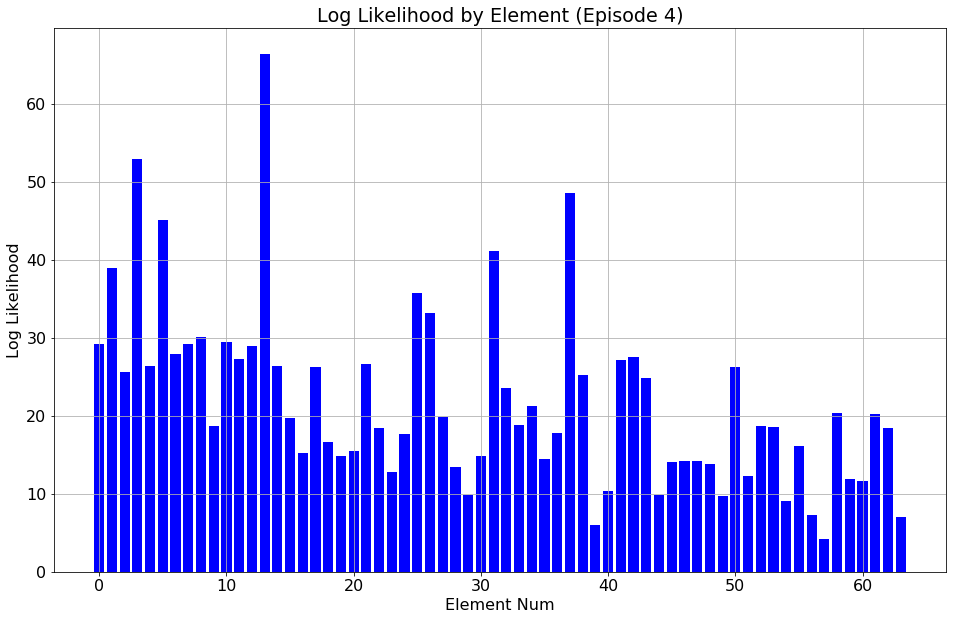

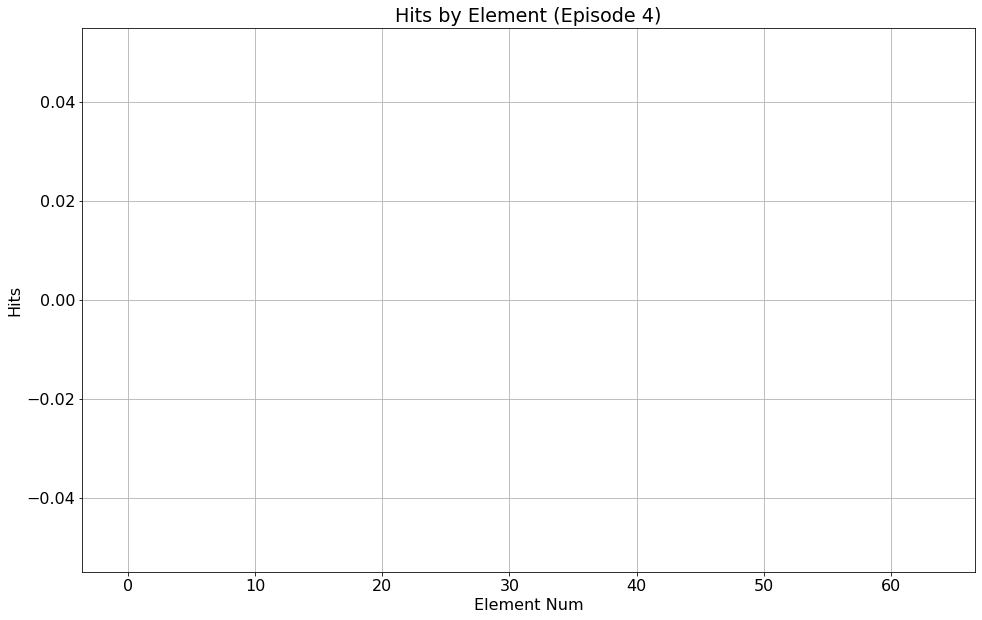


********************************************************************************
Round 2: 5000 batches @ LR 2^-14 with frozen elements.
********************************************************************************
Applying learning_rate 6.10e-05 (2.0^-14.0) for adaptive training.

Training episode 4: Epoch   20, Batch   2000
effective_learning_rate=6.104e-05, training_time 105 sec.
Train on 6400 samples
Epoch 21/25
6400/6400 [==============================] - 6s 894us/sample - loss: -694.1942
Epoch 22/25
6400/6400 [==============================] - 4s 574us/sample - loss: -841.4661
Epoch 23/25
6400/6400 [==============================] - 4s 569us/sample - loss: -926.4895
Epoch 24/25
6400/6400 [==============================] - 4s 567us/sample - loss: -1009.2815
Epoch 25/25
6400/6400 [==============================] - 4s 569us/sample - loss: -1079.7502
Geom Mean Resolution:   1131.71 arc seconds
Geom Mean Threshold :   7200.00 arc seconds
Mean Hits           :      0.06
Mean Log Lik

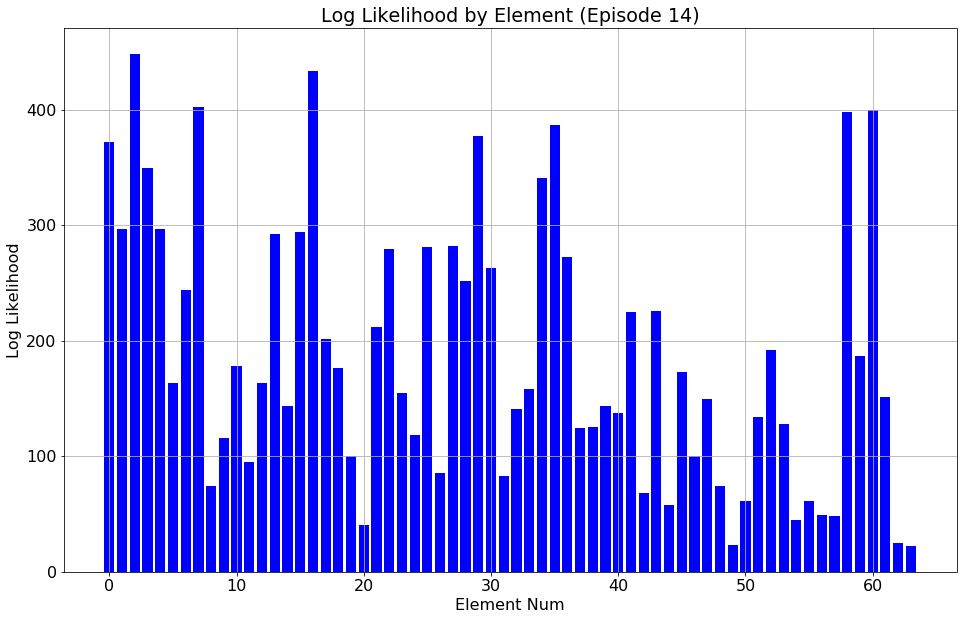

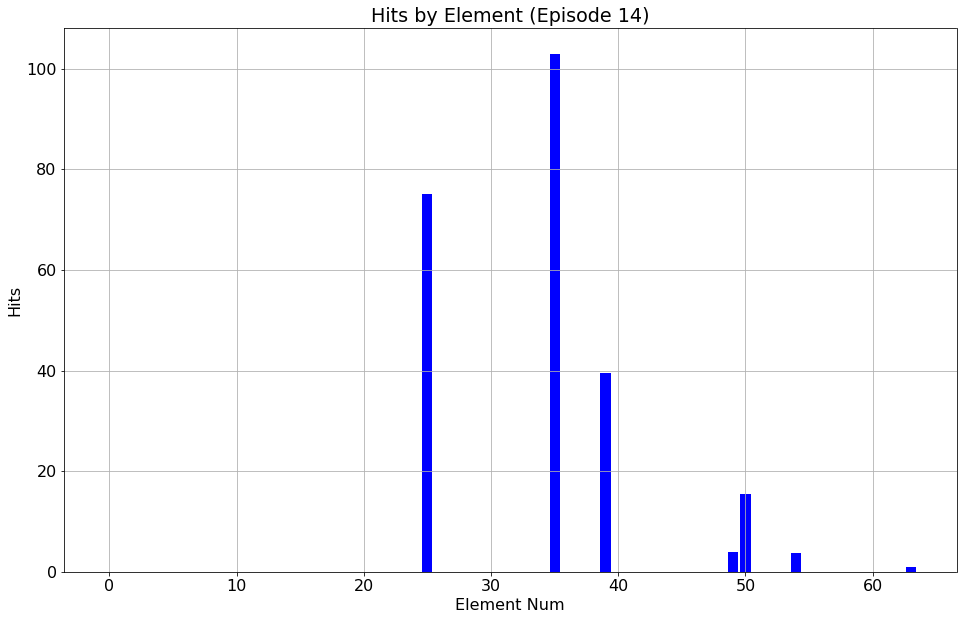


********************************************************************************
Round 3: 1000 batches @ LR 2^-12 with frozen elements.
********************************************************************************

Training episode 14: Epoch   70, Batch   7000
effective_learning_rate=2.612e-05, training_time 312 sec.
Train on 6400 samples
Epoch 71/75
6400/6400 [==============================] - 5s 763us/sample - loss: -5226.1586
Epoch 72/75
6400/6400 [==============================] - 3s 533us/sample - loss: -6552.7979
Epoch 73/75
6400/6400 [==============================] - 3s 533us/sample - loss: -8533.9104
Epoch 74/75
6400/6400 [==============================] - 3s 524us/sample - loss: -11762.4659
Epoch 75/75
6400/6400 [==============================] - 3s 525us/sample - loss: -16938.6678
Adjusted element weight down on 11 candidate elements. Mean weight = 9.14e-01
Geom Mean Resolution:   1248.86 arc seconds
Geom Mean Threshold :   6561.70 arc seconds
Mean Hits           :      

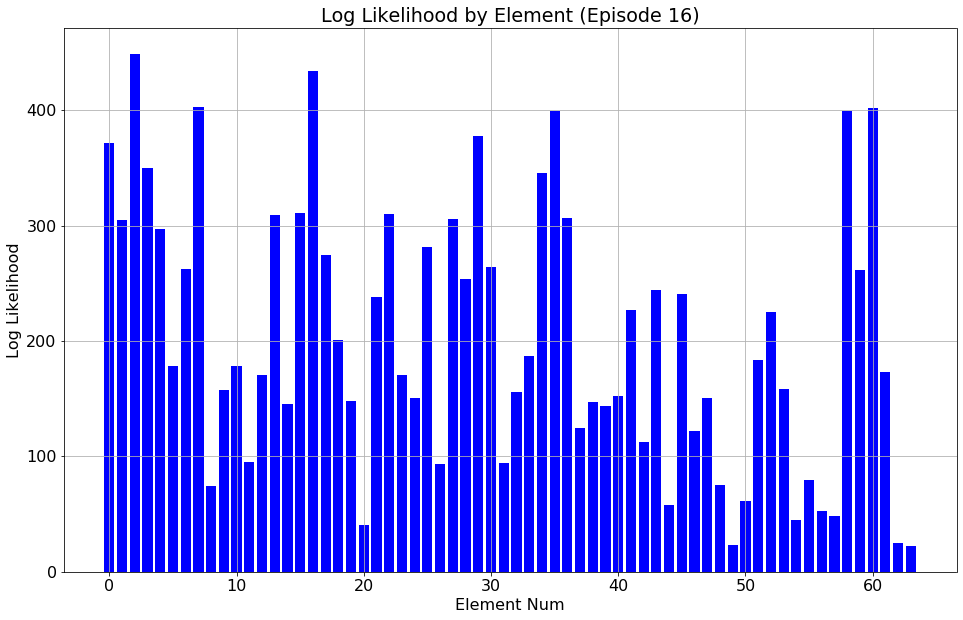

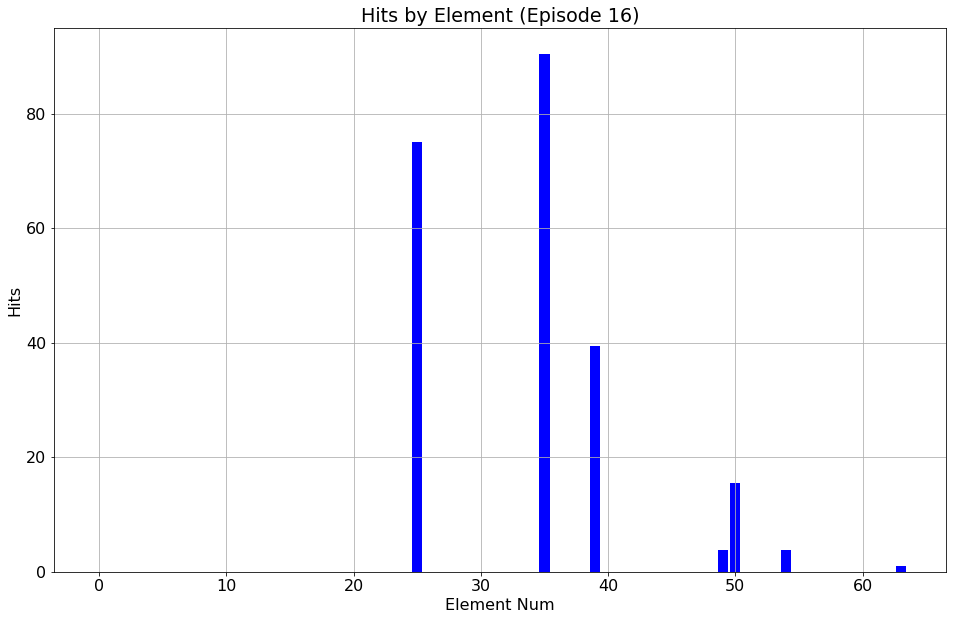


********************************************************************************
Round 4: 5000 batches @ LR 2^-14 with frozen elements.
********************************************************************************
Applying learning_rate 6.10e-05 (2.0^-14.0) for adaptive training.

Training episode 16: Epoch   80, Batch   8000
effective_learning_rate=2.022e-04, training_time 351 sec.
Train on 6400 samples
Epoch 81/85
6400/6400 [==============================] - 6s 966us/sample - loss: -1900.9674
Epoch 82/85
6400/6400 [==============================] - 4s 650us/sample - loss: -1929.1809
Epoch 83/85
6400/6400 [==============================] - 4s 650us/sample - loss: -1964.8508
Epoch 84/85
6400/6400 [==============================] - 4s 656us/sample - loss: -2002.2735
Epoch 85/85
6400/6400 [==============================] - 4s 648us/sample - loss: -2042.6391
Adjusted element weight down on 51 candidate elements. Mean weight = 2.92e-01
Geom Mean Resolution:   1263.58 arc seconds
Geom M

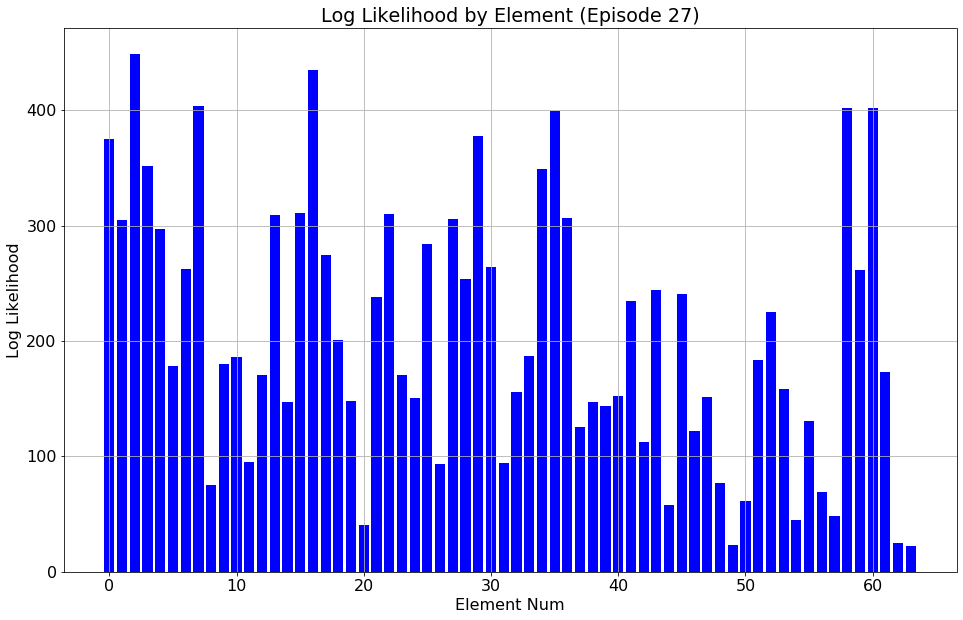

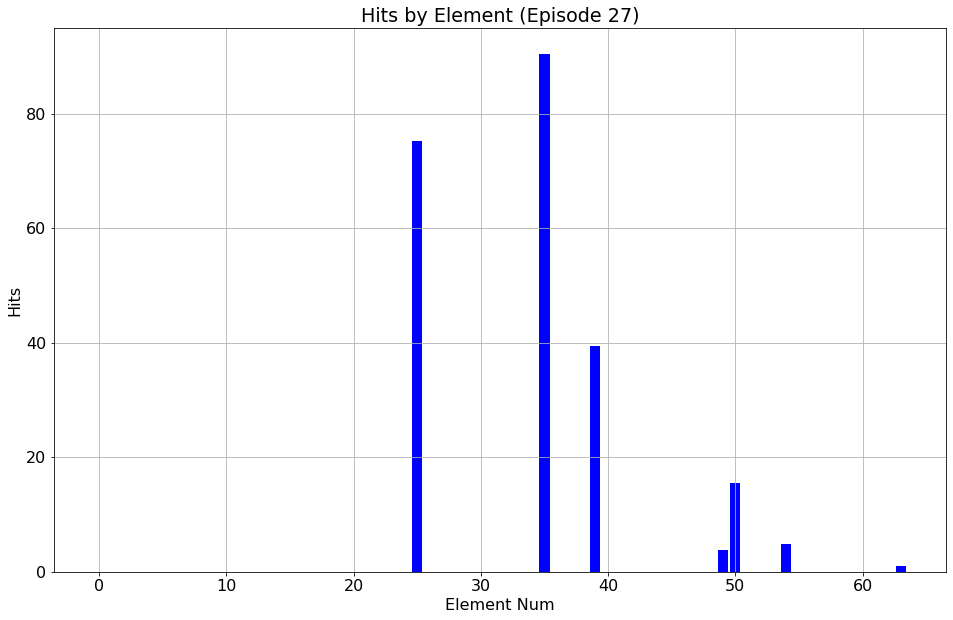


********************************************************************************
Round 3: 1000 batches @ LR 2^-12 with frozen elements.
********************************************************************************

********************************************************************************
Terminating: Effective Learning Rate 5.066e-07 <= minimum 1.907e-06.
********************************************************************************
     \  log_like :  hits  :    R_sec : thresh_sec
Mean   :   205.84  :   3.59 :  1773.31 :  6782.62
Median :   181.72  :   0.00 :  2053.70 :  7200.00
GeoMean:   166.52  :   1.35 :  1269.32 :  6519.37
Std    :   114.26  :  15.22 :   876.94 :  1344.88
Min    :    22.26  :   0.00 :    33.44 :  1419.32
Max    :   448.56  :  90.39 :  3332.77 :  7200.00
Trained for 12600 batches over 126 epochs and 27 episodes.


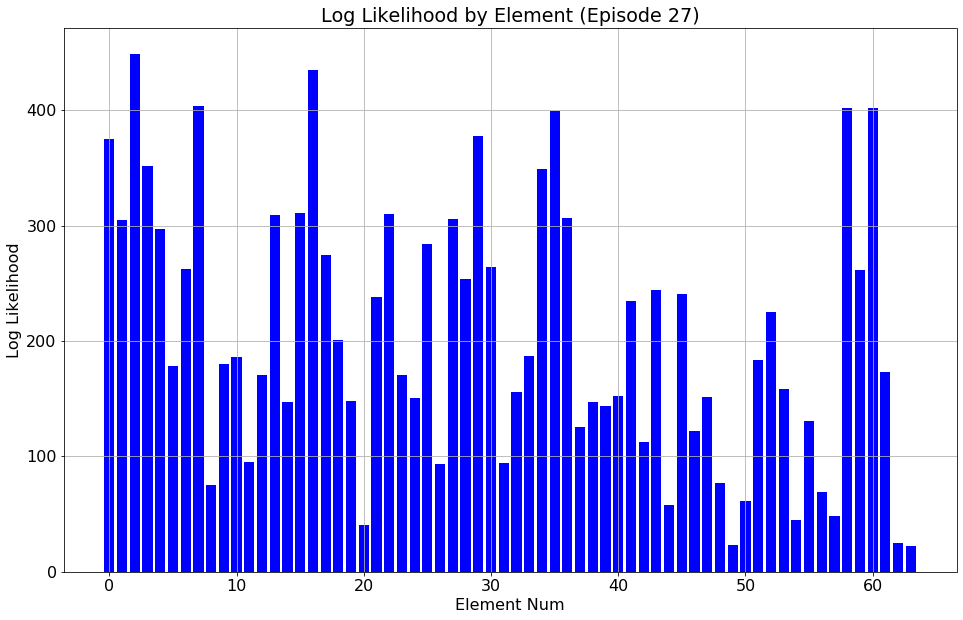

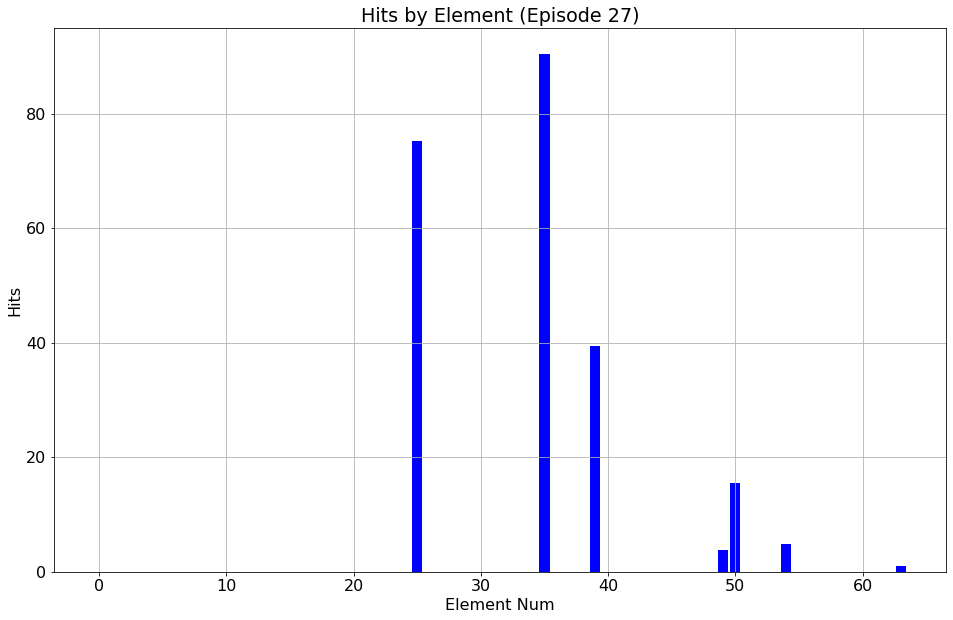

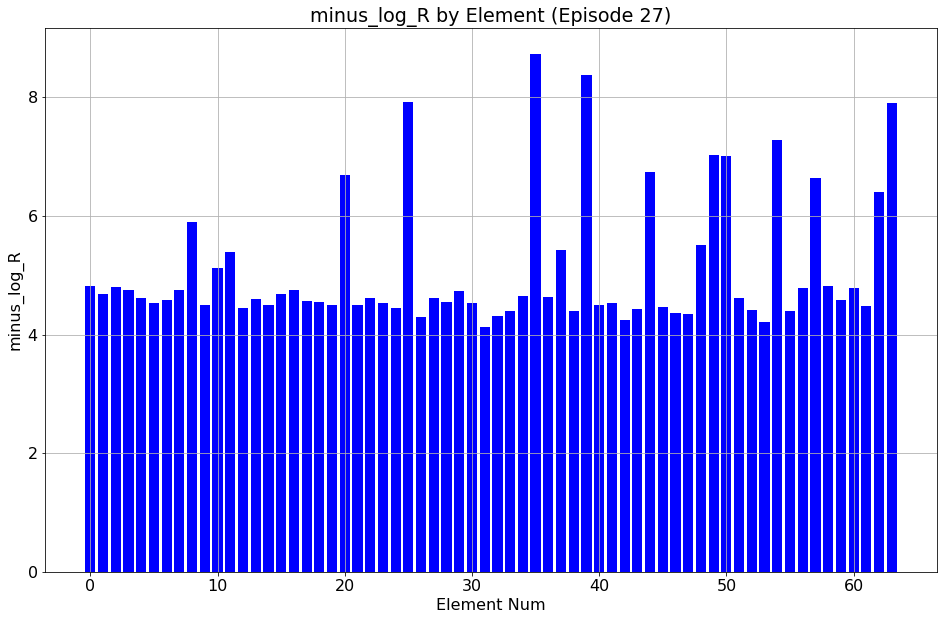

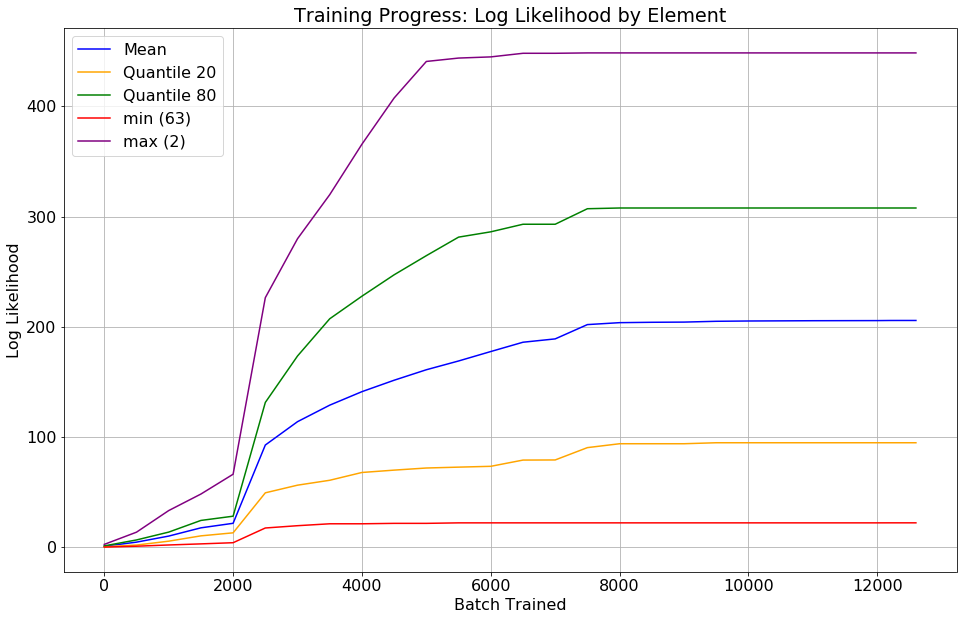

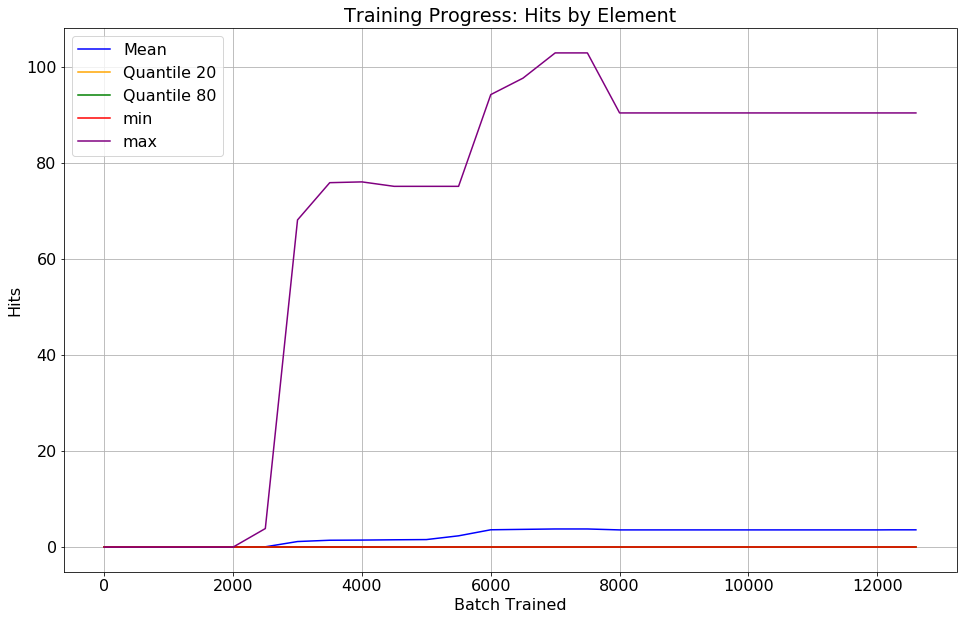

AttributeError: 'DataFrame' object has no attribute 'nearest_ast_dist'

In [26]:
model.sieve(nearest_ast=True)

In [28]:
_ = model.nearest_ast()

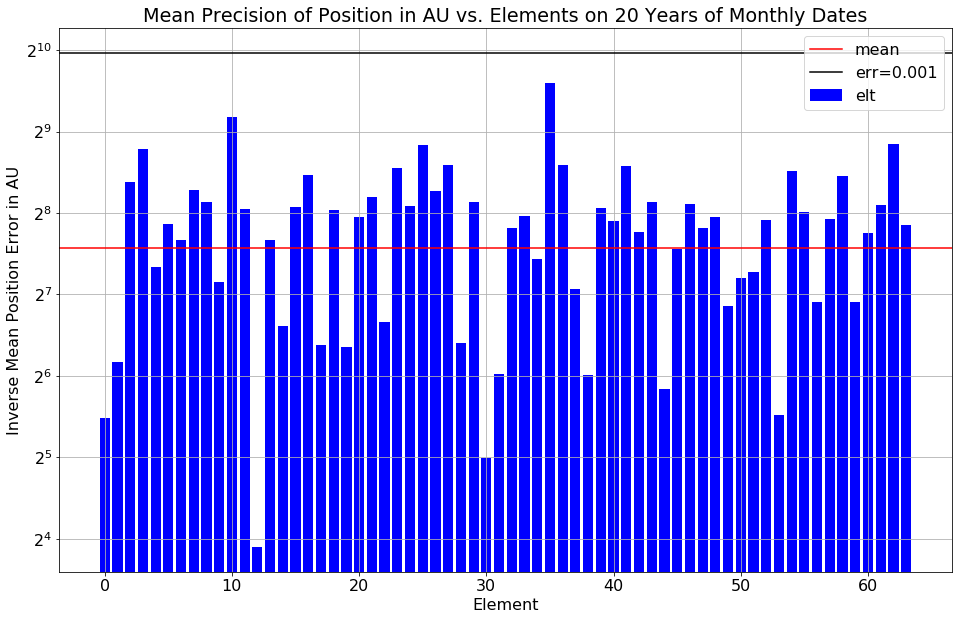

(<Figure size 1152x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f876c092450>)

In [29]:
model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

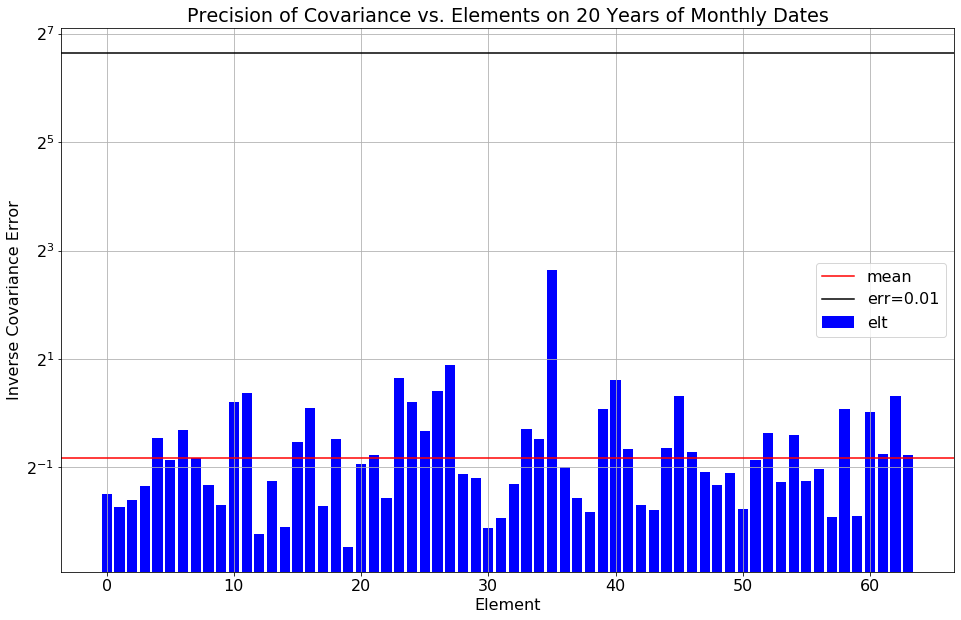

(<Figure size 1152x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f877607d750>)

In [30]:
model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

## Train on Perturbed Elements: Learn Mixture Parameters

In [ ]:
# Visualize log likelihood before traning
fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# Adaptive search parameters
batches_per_epoch = 100
epochs_per_episode = 5
thresh_deg_end = None
max_bad_episodes = 3
min_learning_rate = None
save_at_end = False
reset_active_weight = False
verbose = 1

In [ ]:
# # Train perturbed model with frozen orbital elements
# model.search_adaptive(
#     max_batches=1000,
#     reset_active_weight=True)

In [ ]:
# # Save model
# model.save_state()

In [ ]:
# Load model
model.load()

In [ ]:
model.report()

In [ ]:
# Reduce max threshold
model.set_thresh_deg_max(1.5)

In [ ]:
# Train with frozen orbital elements
model.freeze_candidate_elements()
model.search_adaptive(
    max_batches=model.current_batch + 1000,
    learning_rate=2.0**-15,
    reset_active_weight=True)

In [ ]:
# Train with live orbital elements
model.thaw_candidate_elements()
model.search_adaptive(
    max_batches=model.current_batch + 5000,
    learning_rate=2.0**-12,
    reset_active_weight=True)

In [ ]:
# Report after initial training on mixture parameters
model.report()

In [ ]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('hits', sorted=False)

In [ ]:
# # Bar chart - log likelihood by element
# fig, ax = model.plot_bar('R_deg', sorted=False)

In [ ]:
# # Threshold in degrees
# fig, ax = model.plot_bar('thresh_deg_score', sorted=False)

## Train on Orbital Elements & Mixture Parameters

In [ ]:
# model.save_state()

In [ ]:
# Unfreeze the elements
model.thaw_candidate_elements()

In [ ]:
# Train in joint mode; learn elements, mixture_parameters; threshold frozen
model.search_adaptive(
    max_batches=model.current_batch+100000, 
    learning_rate=2.0**-12,
    reset_active_weight=True)

In [ ]:
# Report after training
model.report()

In [ ]:
# Bar chart 
fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# Bar chart 
fig, ax = model.plot_bar('hits', sorted=False)

In [ ]:
# model.save_state()

In [ ]:
# Freeze elements; train mixture
model.freeze_candidate_elements()
model.freeze_score()

In [ ]:
model.search_adaptive(
    max_batches=model.current_batch+2000,
    learning_rate=2.0**-10,
    reset_active_weight=True)

In [ ]:
# Freeze elements; freeze mixture; train score
model.freeze_candidate_elements()
model.freeze_mixture_parameters()
model.freeze_score()

In [ ]:
model.search_adaptive(
    max_batches=model.current_batch+1000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    reset_active_weight=reset_active_weight,
    verbose=verbose)

In [ ]:
# # Bar chart 
# fig, ax = model.plot_bar('thresh_deg_score', sorted=True)

In [ ]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=True)

## Extended Training

In [ ]:
# model.save_state()

In [ ]:
model.set_thresh_deg_max(1.5)

In [ ]:
# Train on elements only
model.thaw_candidate_elements()
model.freeze_mixture_parameters()
model.freeze_score()

In [ ]:
model.search_adaptive(
    max_batches=model.current_batch+2000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    reset_active_weight=reset_active_weight,
    verbose=verbose)

In [ ]:
model.report()

In [ ]:
model.save_state()

In [ ]:
model.thaw_candidate_elements()
model.thaw_mixture_parameters()

In [ ]:
model.search_adaptive(
    max_batches=model.current_batch+10000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    thresh_deg_start=1.0,
    thresh_deg_end=0.50,
    reset_active_weight=reset_active_weight,    
    verbose=verbose)

In [ ]:
model.report()

In [ ]:
# model.save_state()

In [ ]:
model.freeze_candidate_elements()
model.thaw_mixture_parameters()

In [ ]:
model.search_adaptive(
    max_batches=model.current_batch+1000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    thresh_deg_start=None,
    thresh_deg_end=None,
    reset_active_weight=True,
    verbose=verbose)

In [ ]:
model.save_state()

In [ ]:
model.thaw_candidate_elements()
model.thaw_mixture_parameters()

In [ ]:
model.set_thresh_deg_max(0.75)

In [ ]:
model.search_adaptive(
    max_batches=model.current_batch+5000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    thresh_deg_start=None,
    thresh_deg_end=None,
    reset_active_weight=reset_active_weight,    
    verbose=verbose)

In [ ]:
# model.search_adaptive(
#     max_batches=100000, 
#     batches_per_epoch=batches_per_epoch,
#     epochs_per_episode=epochs_per_episode,
#     learning_rate=2.0**-16,
#     reset_active_weight=True,
#     save_at_end=False,
#     verbose=verbose)

In [ ]:
# model.save_state()

## Review Results Graphically

In [ ]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# Bar chart: hits
fig, ax = model.plot_bar('hits', sorted=False)

In [ ]:
# Bar chart: log likelihood
fig, ax = model.plot_bar('R_deg', sorted=False)

In [ ]:
# Learning curve: log likelihood
fig, ax = model.plot_hist('log_like')

In [ ]:
# # Learning curve: hits
# fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [ ]:
# Find nearest asteroid to fitted elements - search on Cartesian distance
elts_fit, elts_near = model.nearest_ast(search_type='cart')

In [ ]:
# Review fitted elements including nearest asteroid
elts_fit

In [ ]:
q_norm = elt_q_norm(elts=elts_fit, ast_num=elts_fit.nearest_ast_num)
elts_fit['nearest_ast_q_norm'] = q_norm

In [ ]:
# Review asteroids nearest to the fitted elements
elts_near

In [ ]:
# Find nearest asteroid to fitted elements - search on Covariance metric
elts_fit, elts_near = model.nearest_ast(search_type='cov')

In [ ]:
# # Filter for only the good ones
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec < 60)
# elts_fit[mask]

In [ ]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [ ]:
# model.elts_near_ast

In [ ]:
model.elts_fit

In [ ]:
q_norm = elt_q_norm(elts=model.elts_fit, ast_num=model.elts_fit.nearest_ast_num)

In [ ]:
mask = q_norm < 1
np.round(q_norm[mask], 2)

In [ ]:
ast_elt_near_cov = nearest_ast_elt_cov(elts=model.elts_fit)

In [ ]:
ast_elt_near_cov

In [ ]:
dElt = ast_elt_near_cov[cols] - elts_fit[cols]
dElt[62:63]

In [ ]:
X_ast = elts_to_X_cov(ast_elt_near_cov)
U_ast = np.dot(X_ast, beta)
# np.linalg.norm(U_ast, axis=1)
X_ast[62]

In [ ]:
U_ast[62]

In [ ]:
X_elt = elts_to_X_cov(elts_fit)
U_elt = np.dot(U_ast, beta)
X_elt[62:63]

In [ ]:
U_elt[62]

In [ ]:
dU = U_elt - U_ast

In [ ]:
dU[62]

In [ ]:
np.linalg.norm(dU[62])

In [ ]:
ast_elt_near_cov[cols].loc[62].values

In [ ]:
# covariance type difference vs. nearest asteroid element
from nearest_asteroid import beta, X_beta, elts_to_X_cov

In [ ]:
ast_elt

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='a', is_log=True, elt_num=None)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='e', is_log=True, elt_num=None)